In [1]:
# import zipfile

# extract_path = "/content/"
# with zipfile.ZipFile("/content/archive.zip","r") as zip:
#   zip.extractall(extract_path)

In [2]:
import tensorflow as tf
from tensorflow import keras

In [34]:
# Loading the dataset
import os
image_size = (300,300)
batch_size = 36
dataset_path = "/content/UCMerced_LandUse/Images"

class_names = sorted(os.listdir(dataset_path))

In [35]:
import PIL
import numpy as np

image_data = []
labels = []
ss = True

first_images = dict()

for i in range(len(class_names)):
  class_path = os.path.join(dataset_path, class_names[i])
  image_files = os.listdir(class_path)
  ss2=True
  for name in image_files:
    image_path = os.path.join(class_path, name)
    image = PIL.Image.open(image_path)
    image = image.convert("RGB")
    image = image.resize(image_size)
    image_data.append(np.asarray(image))
    vec = [0 for x in range(21)]
    vec[i]=1
    labels.append(vec)
    if ss2==True:
      first_images[class_names[i]]=np.asarray(image)
      ss2=False
    if ss==True:
      print(len(image_files),"Images in each class")
      print(image.size)
      print(image.format)
      print(image.mode)
      ss=False

100 Images in each class
(300, 300)
None
RGB


In [36]:
print('Loaded a total of :',len(image_data)," with labels")

Loaded a total of : 2100  with labels


In [37]:
from tensorflow import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split

image_data = np.array(image_data)
lables = np.array(labels)

X_train, X_val, y_train, y_val = train_test_split(image_data, labels, test_size=0.2, random_state=42, stratify=labels)

In [38]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size).shuffle(69).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

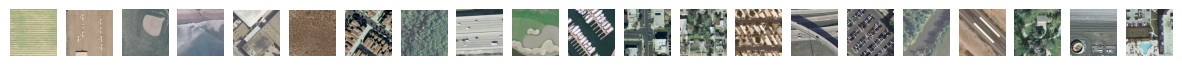

In [39]:
import matplotlib.pyplot as plt

# Create a figure with subplots for each class
fig, axes = plt.subplots(1, len(class_names), figsize=(15, 5))

# Dictionary to store first occurrence of each class
# first_images = {}

# # Find the first occurrence of each class in X_train
# for img, label in zip(X_train, y_train):
#     if label not in first_images:  # Store first found image of this class
#         first_images[label] = img

# Plot images
for ax, class_index in zip(axes, first_images.keys()):
    ax.imshow(first_images[class_index])
    # ax.set_title(class_index)
    ax.axis("off")

plt.show()

In [40]:
def create_network(input_shape, class_num):
  input_tensor = keras.Input(shape=input_shape)
  x = keras.layers.Conv2D(32, (3, 3), activation="relu")(input_tensor)
  x = keras.layers.MaxPooling2D()(x)
  x = keras.layers.Conv2D(64, (3, 3), activation="relu")(x)
  x = keras.layers.MaxPooling2D()(x)
  x = keras.layers.Conv2D(128, (3, 3), activation="relu")(x)
  x = keras.layers.GlobalAveragePooling2D()(x)
  output_tensor = keras.layers.Dense(class_num, activation="softmax")(x)

  model = keras.Model(inputs=input_tensor, outputs=output_tensor)

  model.compile(optimizer="adam",
                loss="categorical_crossentropy",
                metrics=["accuracy"])
  return model

In [41]:
model = create_network(input_shape=(300,300,3), class_num=21)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 300, 300, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 298, 298, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 149, 149, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 147, 147, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 73, 73, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 71, 71, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 21)                  │           2,709 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 95,957 (374.83 KB)

 Trainable params: 95,957 (374.83 KB)

 Non-trainable params: 0 (0.00 B)

In [42]:
import cv2
def generate_cam(model, image, class_index):
  last_conv_layer = model.get_layer("conv2d_11")
  feature_map_model = keras.Model(inputs=model.input, outputs=last_conv_layer.output)
  final_dense_layer = model.get_layer("dense_3")
  class_weights = final_dense_layer.get_weights()[0]

  conv_output = feature_map_model(np.array([image]))
  conv_output = conv_output[0]

  cam = np.dot(conv_output, class_weights[:, class_index])
  cam = np.maximum(cam,0)
  cam = cam/np.max(cam)

  cam = np.uint8(255*cam)
  cam = cv2.applyColorMap(cam, cv2.COLORMAP_JET)
  overlayed_img = cv2.addWeighted(image, 0.5, cam, 0.5, 0)
  return overlayed_img

In [43]:
tf.debugging.set_log_device_placement(True)

# Check if TensorFlow is running on GPU
device_name = tf.test.gpu_device_name()
if device_name:
    print(f"Using GPU: {device_name}")
else:
    print("No GPU found, using CPU instead.")

Using GPU: /device:GPU:0


In [44]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=45
)

Epoch 1/45
47/47 ━━━━━━━━━━━━━━━━━━━━ 23s 278ms/step - accuracy: 0.0695 - loss: 13.3551 - val_accuracy: 0.1619 - val_loss: 2.8131
Epoch 2/45
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.1745 - loss: 2.6965 - val_accuracy: 0.2190 - val_loss: 2.4128
Epoch 3/45
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.2959 - loss: 2.2394 - val_accuracy: 0.3071 - val_loss: 2.2040
Epoch 4/45
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.3464 - loss: 2.1029 - val_accuracy: 0.3333 - val_loss: 2.1963
Epoch 5/45
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.3845 - loss: 1.8931 - val_accuracy: 0.3738 - val_loss: 2.0126
Epoch 6/45
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.4290 - loss: 1.7944 - val_accuracy: 0.4167 - val_loss: 1.8647
Epoch 7/45
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - accuracy: 0.4620 - loss: 1.7112 - val_accuracy: 0.4310 - val_loss: 1.8172
Epoch 8/45
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.5010 - loss: 1.6277 - val_accuracy: 0.4167 

In [45]:
for i in range(len(class_names)):
  print("Mapping ",i,"::",class_names[i])

Mapping  0 :: agricultural
Mapping  1 :: airplane
Mapping  2 :: baseballdiamond
Mapping  3 :: beach
Mapping  4 :: buildings
Mapping  5 :: chaparral
Mapping  6 :: denseresidential
Mapping  7 :: forest
Mapping  8 :: freeway
Mapping  9 :: golfcourse
Mapping  10 :: harbor
Mapping  11 :: intersection
Mapping  12 :: mediumresidential
Mapping  13 :: mobilehomepark
Mapping  14 :: overpass
Mapping  15 :: parkinglot
Mapping  16 :: river
Mapping  17 :: runway
Mapping  18 :: sparseresidential
Mapping  19 :: storagetanks
Mapping  20 :: tenniscourt


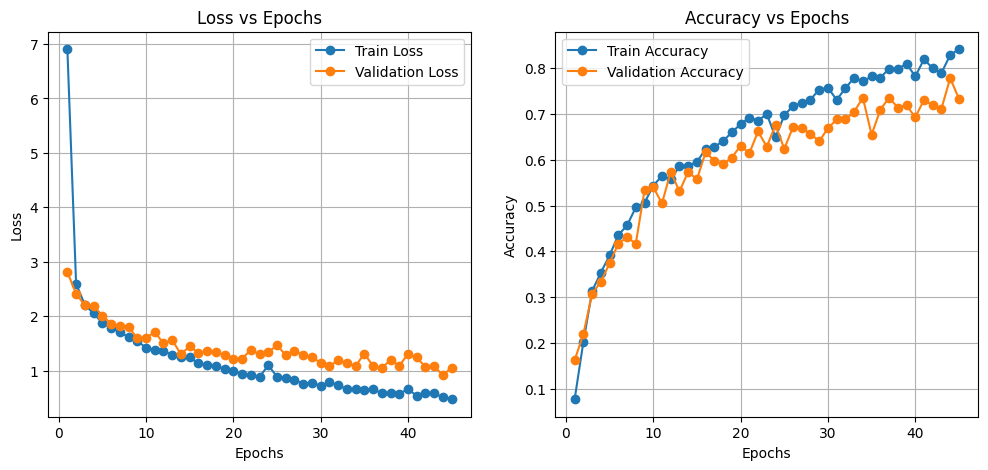

In [46]:
import matplotlib.pyplot as plt

# Plotting the Accuracy ad Loss for the CNN
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].plot(epochs, train_loss, label="Train Loss", marker="o")
axes[0].plot(epochs, val_loss, label="Validation Loss", marker="o")
axes[0].set_title("Loss vs Epochs")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid()
axes[1].plot(epochs, train_acc, label="Train Accuracy", marker="o")
axes[1].plot(epochs, val_acc, label="Validation Accuracy", marker="o")
axes[1].set_title("Accuracy vs Epochs")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Accuracy")
axes[1].legend()
axes[1].grid()
plt.show()


In [65]:
import cv2
def generate_cam(model, image, class_index):
  last_conv_layer = model.get_layer("conv2d_11")
  feature_map_model = keras.Model(inputs=model.input, outputs=last_conv_layer.output)
  final_dense_layer = model.get_layer("dense_3")
  class_weights = final_dense_layer.get_weights()[0]

  conv_output = feature_map_model(np.array([image]))
  conv_output = conv_output[0]

  cam = np.dot(conv_output, class_weights[:, class_index])
  cam = np.maximum(cam,0)
  cam = cam/np.max(cam)

  cam = np.uint8(255*cam)
  cam = cv2.applyColorMap(cam, cv2.COLORMAP_JET)

  # Convert cam to 3 channels (RGB) to match image
  cam = cv2.cvtColor(cam, cv2.COLOR_BGR2RGB)
  cam = cv2.resize(cam, (300, 300),
               interpolation = cv2.INTER_LINEAR)

  overlayed_img = cv2.addWeighted(image, 0.6, cam, 0.4, 0)
  return overlayed_img

In [66]:
cam_images = dict()
for i in range(len(class_names)):
  class_name = class_names[i]
  class_path = os.path.join(dataset_path, class_name)
  image_name = os.listdir(class_path)[0]
  image_path = os.path.join(class_path, image_name)
  img = PIL.Image.open(image_path)
  img = img.resize(image_size)
  img = np.asarray(img)
  overlayed_image = generate_cam(model,img,i)
  cam_images[class_name] = overlayed_image

array([[[146, 223, 171],
        [147, 222, 171],
        [143, 221, 172],
        ...,
        [136, 199, 129],
        [138, 201, 131],
        [138, 201, 131]],

       [[141, 215, 163],
        [139, 213, 161],
        [136, 212, 161],
        ...,
        [132, 195, 125],
        [135, 197, 128],
        [135, 197, 130]],

       [[128, 205, 151],
        [127, 203, 150],
        [124, 202, 150],
        ...,
        [132, 196, 127],
        [134, 198, 130],
        [134, 198, 130]],

       ...,

       [[181, 161,  50],
        [178, 160,  48],
        [181, 159,  53],
        ...,
        [220, 208,  92],
        [222, 209,  92],
        [222, 210,  92]],

       [[206, 184,  71],
        [203, 181,  68],
        [205, 179,  72],
        ...,
        [232, 227, 105],
        [233, 227, 104],
        [233, 227, 104]],

       [[228, 207,  97],
        [226, 205,  96],
        [226, 199,  96],
        ...,
        [235, 230, 108],
        [235, 231, 107],
        [236, 232, 108]]], dtype=uint8)
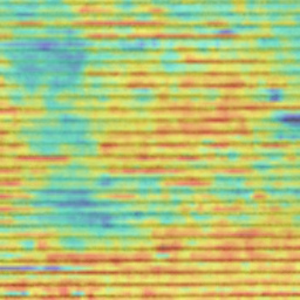

In [67]:
cam_images['agricultural']

array([[[129, 128, 177],
        [128, 127, 176],
        [130, 129, 178],
        ...,
        [ 36,  35,  93],
        [ 39,  38,  96],
        [ 46,  44, 102]],

       [[128, 127, 177],
        [128, 128, 178],
        [130, 130, 178],
        ...,
        [ 47,  46, 103],
        [ 45,  44, 100],
        [ 43,  44, 100]],

       [[125, 124, 175],
        [127, 127, 176],
        [127, 127, 176],
        ...,
        [ 55,  54, 111],
        [ 49,  49, 105],
        [ 40,  41,  99]],

       ...,

       [[106, 105, 164],
        [107, 106, 165],
        [109, 109, 169],
        ...,
        [ 48,  50, 115],
        [ 48,  49, 116],
        [ 48,  49, 114]],

       [[103, 102, 158],
        [104, 104, 160],
        [108, 107, 165],
        ...,
        [ 50,  50, 116],
        [ 50,  50, 117],
        [ 49,  49, 116]],

       [[103, 103, 159],
        [103, 103, 159],
        [107, 107, 165],
        ...,
        [ 50,  49, 115],
        [ 50,  49, 115],
        [ 49,  50, 117]]], dtype=uint8)
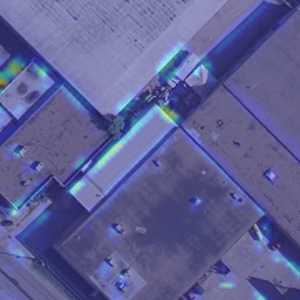

In [68]:
cam_images['buildings']

array([[[126, 190, 149],
        [124, 188, 148],
        [122, 187, 149],
        ...,
        [109,  97, 166],
        [109,  97, 166],
        [108,  95, 165]],

       [[126, 190, 150],
        [124, 189, 148],
        [123, 188, 150],
        ...,
        [109,  96, 166],
        [109,  96, 165],
        [108,  95, 165]],

       [[128, 187, 158],
        [123, 184, 154],
        [119, 183, 153],
        ...,
        [107,  95, 164],
        [107,  94, 163],
        [106,  94, 164]],

       ...,

       [[104,  99, 146],
        [103,  97, 145],
        [104, 101, 149],
        ...,
        [106,  94, 161],
        [106,  94, 161],
        [105,  93, 161]],

       [[105,  99, 146],
        [103,  97, 145],
        [104, 102, 150],
        ...,
        [109,  96, 164],
        [109,  96, 164],
        [108,  95, 163]],

       [[104,  98, 145],
        [101,  95, 143],
        [104, 100, 148],
        ...,
        [107,  95, 163],
        [107,  95, 163],
        [108,  95, 163]]], dtype=uint8)
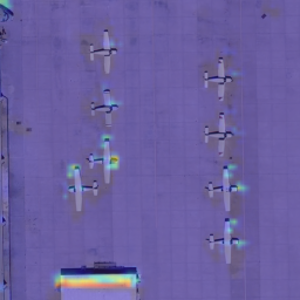

In [69]:
cam_images['airplane']

array([[[100, 105, 157],
        [101, 106, 160],
        [101, 107, 163],
        ...,
        [110, 116, 168],
        [111, 118, 169],
        [112, 118, 169]],

       [[ 95,  99, 153],
        [ 97, 103, 156],
        [ 98, 104, 160],
        ...,
        [ 98, 101, 152],
        [ 97, 100, 151],
        [ 94,  99, 150]],

       [[ 94,  98, 151],
        [ 96, 100, 154],
        [ 97, 101, 156],
        ...,
        [ 97, 101, 154],
        [ 94,  99, 150],
        [ 91,  96, 148]],

       ...,

       [[115, 122, 172],
        [117, 122, 172],
        [118, 123, 172],
        ...,
        [103, 120, 213],
        [ 94, 110, 204],
        [ 90, 105, 200]],

       [[116, 124, 172],
        [117, 125, 174],
        [119, 125, 175],
        ...,
        [ 51,  67, 160],
        [ 53,  66, 160],
        [ 36,  49, 144]],

       [[118, 128, 175],
        [118, 126, 174],
        [119, 128, 176],
        ...,
        [ 12,  23, 120],
        [ 47,  58, 158],
        [ 47,  59, 159]]], dtype=uint8)
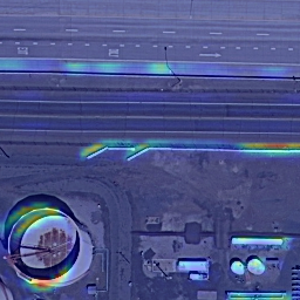

In [70]:
cam_images['storagetanks']

array([[[ 19,  31, 124],
        [ 15,  29, 116],
        [ 19,  34, 118],
        ...,
        [ 20,  44, 131],
        [ 21,  46, 131],
        [ 19,  45, 131]],

       [[ 17,  30, 121],
        [ 20,  35, 123],
        [ 22,  38, 127],
        ...,
        [ 22,  45, 134],
        [ 22,  46, 134],
        [ 18,  42, 133]],

       [[ 28,  41, 130],
        [ 29,  45, 132],
        [ 26,  43, 132],
        ...,
        [ 20,  44, 139],
        [ 20,  44, 138],
        [ 20,  46, 139]],

       ...,

       [[ 58, 105, 170],
        [ 73, 118, 184],
        [ 91, 132, 200],
        ...,
        [131, 121, 168],
        [127, 118, 163],
        [109, 104, 153]],

       [[ 52,  99, 166],
        [ 62, 110, 176],
        [ 74, 118, 187],
        ...,
        [131, 122, 170],
        [117, 110, 155],
        [ 92,  88, 135]],

       [[ 51,  99, 169],
        [ 50,  98, 167],
        [ 58, 102, 174],
        ...,
        [128, 119, 170],
        [109, 102, 149],
        [ 80,  76, 124]]], dtype=uint8)
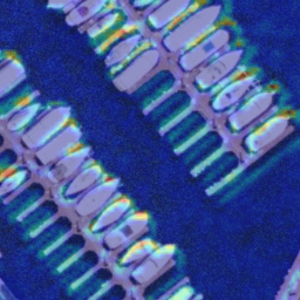

In [71]:
cam_images['harbor']

array([[[110, 132, 203],
        [110, 132, 204],
        [107, 130, 203],
        ...,
        [ 94, 108, 188],
        [ 96, 109, 189],
        [ 92, 108, 190]],

       [[ 88, 111, 187],
        [ 89, 112, 187],
        [ 86, 110, 186],
        ...,
        [108, 119, 205],
        [110, 119, 204],
        [109, 121, 205]],

       [[ 76, 104, 176],
        [ 77, 104, 176],
        [ 76, 104, 175],
        ...,
        [113, 127, 212],
        [116, 127, 212],
        [114, 127, 212]],

       ...,

       [[ 87,  92, 141],
        [ 92,  97, 145],
        [ 93,  98, 143],
        ...,
        [111, 112, 155],
        [110, 111, 153],
        [103, 110, 145]],

       [[ 88,  92, 140],
        [ 90,  92, 143],
        [ 91,  94, 142],
        ...,
        [104, 106, 151],
        [101, 102, 147],
        [ 88,  99, 138]],

       [[ 93,  98, 144],
        [ 94,  99, 146],
        [ 91,  96, 144],
        ...,
        [100, 104, 150],
        [ 95, 101, 145],
        [ 76,  95, 135]]], dtype=uint8)
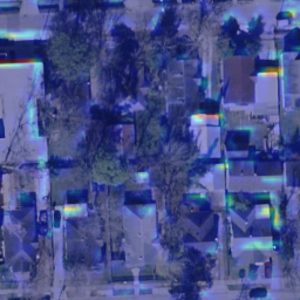

In [73]:
cam_images['mediumresidential']

array([[[113, 129, 177],
        [112, 127, 173],
        [114, 127, 172],
        ...,
        [  2,  51, 113],
        [  1,  49, 113],
        [  1,  48, 113]],

       [[112, 128, 175],
        [111, 125, 171],
        [115, 127, 172],
        ...,
        [  1,  51, 113],
        [  0,  48, 112],
        [  1,  49, 112]],

       [[112, 127, 173],
        [113, 125, 170],
        [117, 127, 172],
        ...,
        [  1,  54, 110],
        [  0,  53, 110],
        [  2,  54, 112]],

       ...,

       [[ 90,  83, 125],
        [ 82,  74, 117],
        [ 77,  69, 112],
        ...,
        [115, 106, 146],
        [113, 104, 145],
        [110, 100, 142]],

       [[101,  95, 138],
        [ 94,  88, 130],
        [ 86,  80, 123],
        ...,
        [113, 104, 145],
        [105,  97, 139],
        [ 91,  81, 124]],

       [[105, 101, 143],
        [101,  97, 139],
        [ 94,  91, 133],
        ...,
        [109, 100, 142],
        [ 95,  86, 129],
        [ 70,  62, 106]]], dtype=uint8)
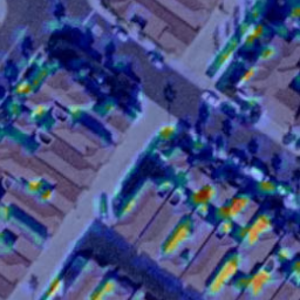

In [74]:
cam_images['denseresidential']